<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Authors: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by Gleb Filatov, Aleksey Kiselev, [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #3 (demo). Solution
## <center>  Decision trees with a toy task and the UCI Adult dataset 

Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution). Fill in the answers in the [web-form](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Let's start by loading all necessary libraries:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

import collections

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Part 1. Toy dataset "Will They? Won't They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We'll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

#### Creating the dataset

In [6]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [7]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

#### Training data

In [9]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


#### Test data

In [11]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,True,False,True,False,True,False,False,True
1,True,False,False,True,False,True,True,False
2,False,True,False,True,True,False,False,True


In [12]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Alcoholic_beverage_no,Money_spent_lots,Eloquence_high,Money_spent_little,Eloquence_average,Looks_repulsive,Looks_handsome,Alcoholic_beverage_yes
0,False,True,True,False,False,False,True,True
1,False,False,False,True,False,False,True,True
2,True,True,False,False,True,False,True,False
3,True,False,False,True,True,True,False,False
4,False,True,False,False,False,True,False,True
5,False,True,True,False,False,True,False,True
6,False,True,False,False,True,False,True,True


In [13]:
df_test

,Alcoholic_beverage_no,Money_spent_lots,Eloquence_high,Money_spent_little,Eloquence_average,Looks_repulsive,Looks_handsome,Alcoholic_beverage_yes
0,True,True,False,False,True,False,True,False
1,False,False,True,True,False,False,True,True
2,False,True,False,False,True,True,False,True


#### Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

1\. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

<font color='red'>Answer: </font>  $S_0 = -\frac{3}{7}\log_2{\frac{3}{7}}-\frac{4}{7}\log_2{\frac{4}{7}} = 0.985$.

2\. Let's split the data by the feature "Looks_handsome". What is the entropy $S_1$ of the left group - the one with "Looks_handsome". What is the entropy $S_2$ in the opposite group? What is the information gain (IG) if we consider such a split?

<font color='red'>Answer: </font> $S_1 = -\frac{1}{4}\log_2{\frac{1}{4}}-\frac{3}{4}\log_2{\frac{3}{4}} = 0.811$, $S_2 = -\frac{2}{3}\log_2{\frac{2}{3}}-\frac{1}{3}\log_2{\frac{1}{3}} = 0.918$, $IG = S_0-\frac{4}{7}S_1-\frac{3}{7}S_2 = 0.128$.

#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [30]:
dt = DecisionTreeClassifier(criterion="entropy", random_state=17)
dt.fit(df_train, y);

#### Additional: display the resulting tree using graphviz.

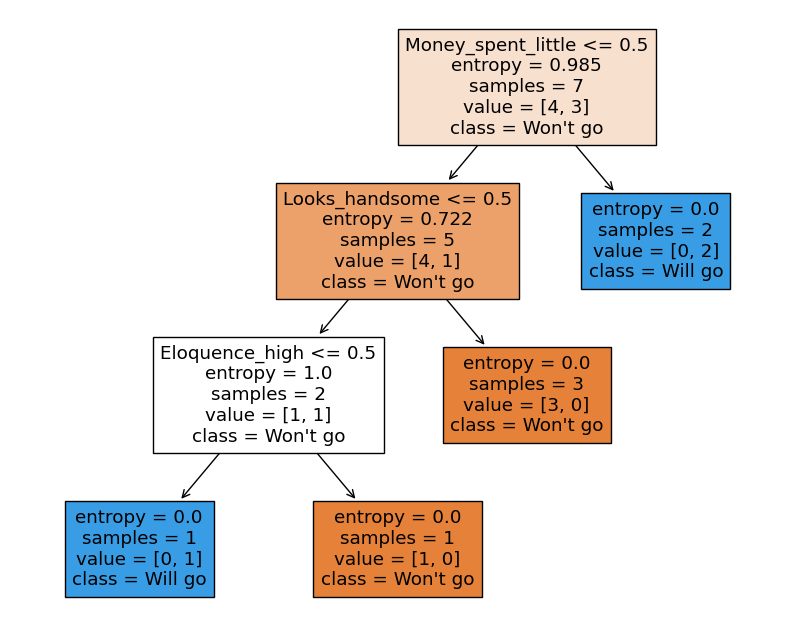

In [33]:
plot_tree(
    dt, feature_names=df_train.columns, filled=True, class_names=["Won't go", "Will go"]
);

### Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label **1** if it is blue, **0** otherwise.

In [37]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src = '../../img/decision_tree3.png'>

Next split the balls into two groups:

<img src = '../../img/decision_tree4.png'>

In [42]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

#### Implement a function to calculate the Shannon Entropy

In [45]:
from math import log


def entropy(a_list):
    lst = list(a_list)
    size = len(lst)
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0, 1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ / size * log(occ / size, 2)
    return entropy

Tests

In [47]:
print(entropy(balls))  # 9 blue and 11 yellow ones
print(entropy(balls_left))  # 8 blue and 5 yellow ones
print(entropy(balls_right))  # 1 blue and 6 yellow ones
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


3\. What is the entropy of the state given by the list **balls_left**?

<font color='red'>Answer:</font> 0.961

4\. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

<font color='red'>Answer:</font> 2.585

In [49]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""

    return (
        entropy(root)
        - 1.0 * len(left) / len(root) * entropy(left)
        - 1.0 * len(right) / len(root) * entropy(right)
    )

In [51]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


5\. What is the information gain from splitting the initial dataset into **balls_left** and **balls_right** ?

<font color='red'>Answer:</font> 0.161

In [53]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return out

#### Optional:
- Implement a decision tree building algorithm by calling `information_gains` recursively
- Plot the resulting tree

In [ ]:
information_gains(df_train, y)

In [ ]:
def btree(X, y, feature_names):
    clf = information_gains(X, y)
    best_feat_id = clf.index(max(clf))
    best_feature = feature_names[best_feat_id]
    print(f"Best feature to split: {best_feature}")

    x_left = X[X.iloc[:, best_feat_id] == 0]
    x_right = X[X.iloc[:, best_feat_id] == 1]
    print(f"Samples: {len(x_left)} (left) and {len(x_right)} (right)")

    y_left = y[X.iloc[:, best_feat_id] == 0]
    y_right = y[X.iloc[:, best_feat_id] == 1]
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    print(f"Entropy: {entropy_left} (left) and {entropy_right} (right)")
    print("_" * 30 + "\n")
    if entropy_left != 0:
        print(f"Splitting the left group with {len(x_left)} samples:")
        btree(x_left, y_left, feature_names)
    if entropy_right != 0:
        print(f"Splitting the right group with {len(x_right)} samples:")
        btree(x_right, y_right, feature_names)

In [ ]:
btree(df_train, y, df_train.columns)

This visualization is far from perfect, but it's easy to grasp if you compare it to the normal tree visualization (by sklearn) done above.

### Part 3. The "Adult" dataset

#### Dataset description:

[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographical data - whether they earn more than \$50,000 per year or not.

Feature descriptions:

- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Martial_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

#### Reading train and test data

In [ ]:
data_train = pd.read_csv("../../data/adult_train.csv", sep=";")

In [ ]:
data_train.tail()

In [ ]:
data_test = pd.read_csv("../../data/adult_test.csv", sep=";")

In [ ]:
data_test.tail()

In [ ]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

#### Primary data analysis

In [ ]:
data_test.describe(include="all").T

In [ ]:
data_train["Target"].value_counts()

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Checking data types

In [ ]:
data_train.dtypes

In [ ]:
data_test.dtypes

As we see, in the test data, age is treated as type **object**. We need to fix this.

In [ ]:
data_test["Age"] = data_test["Age"].astype(int)

Also we'll cast all **float** features to **int** type to keep types consistent between our train and test data.

In [ ]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

#### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [ ]:
# we see some missing values
data_train.info()

In [ ]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

In [ ]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [ ]:
# no more missing values
data_train.info()

We'll dummy code some categorical features: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. It can be done via pandas method **get_dummies**

In [ ]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [ ]:
set(data_train.columns) - set(data_test.columns)

In [ ]:
data_train.shape, data_test.shape

#### There is no Holland in the test data. Create new zero-valued feature.

In [ ]:
data_test["Country_ Holand-Netherlands"] = 0

In [ ]:
set(data_train.columns) - set(data_test.columns)

In [ ]:
data_train.head(2)

In [ ]:
data_test.head(2)

In [ ]:
X_train = data_train.drop(["Target"], axis=1)
y_train = data_train["Target"]

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

### 3.1 Decision tree without parameter tuning

Train a decision tree **(DecisionTreeClassifier)** with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter **random_state = 17** for results reproducibility.

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

Make a prediction with the trained model on the test data.

In [ ]:
X_test = X_test[X_train.columns] # The feature names should match those that were passed during fit
tree_predictions = tree.predict(X_test)

In [ ]:
accuracy_score(y_test, tree_predictions)

6\. What is the test set accuracy of a decision tree with maximum tree depth of 3 and **random_state = 17**?

### 3.2 Decision tree with parameter tuning

Train a decision tree **(DecisionTreeClassifier, random_state = 17).** Find the optimal maximum depth using 5-fold cross-validation **(GridSearchCV)**.

In [ ]:
%%time
tree_params = {"max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17), tree_params, cv=5
)

locally_best_tree.fit(X_train, y_train)

In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Train a decision tree with maximum depth of 9 (it is the best **max_depth** in my case), and compute the test set accuracy. Use parameter **random_state = 17** for reproducibility.

In [ ]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

7\. What is the test set accuracy of a decision tree with maximum depth of 9 and **random_state = 17**?

<font color='red'>Answer:</font> 0.848

### 3.3 (Optional) Random forest without parameter tuning

Let's take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest **(RandomForestClassifier)**. Set the number of trees to 100 and use **random_state = 17**.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

Perfrom cross-validation.

In [ ]:
%%time
cv_scores = cross_val_score(rf, X_train, y_train, cv=3)

In [ ]:
cv_scores, cv_scores.mean()

Make predictions for the test data.

In [ ]:
forest_predictions = rf.predict(X_test)

In [ ]:
accuracy_score(y_test, forest_predictions)

### 3.4 (Optional) Random forest with parameter tuning

Train a random forest **(RandomForestClassifier)** of 10 trees. Tune the maximum depth and maximum number of features for each tree using **GridSearchCV**. 

In [ ]:
forest_params = {"max_depth": range(10, 16), "max_features": range(5, 105, 20)}

locally_best_forest = GridSearchCV(
    RandomForestClassifier(n_estimators=10, random_state=17, n_jobs=-1),
    forest_params,
    cv=3,
    verbose=1,
)

locally_best_forest.fit(X_train, y_train)

In [ ]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Make predictions for the test data.

In [ ]:
tuned_forest_predictions = locally_best_forest.predict(X_test)
accuracy_score(y_test, tuned_forest_predictions)

Wow! Looks that with some tuning we made a forest of 10 trees perform better than a forest of 100 trees with default hyperparameter values. 